In [101]:
import matplotlib.pyplot as plt
import os
import numpy as np
import seaborn as sns

from sklearn.metrics import confusion_matrix
from tensorflow.keras import layers, models, applications, losses, metrics
import tensorflow as tf
from sklearn.model_selection import train_test_split
from pathlib import Path
from PIL import Image


In [102]:
RAW_WIDTH = 640
RAW_HEIGHT = 360


In [103]:
yes0_koi_img = Image.open("yes_0.png")
no0_koi_img = Image.open("no_0.png")
yes1_koi_img = Image.open("yes_1.png")
no1_koi_img = Image.open("no_1.png")


# RAW


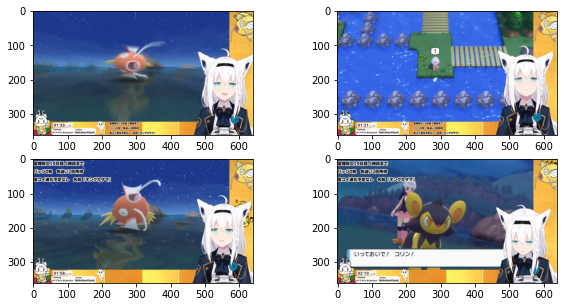

In [104]:
_, ax = plt.subplots(2, 2, figsize=(10, 5))
ax[0, 0].imshow(yes0_koi_img)
ax[0, 1].imshow(no0_koi_img)
ax[1, 0].imshow(yes1_koi_img)
ax[1, 1].imshow(no1_koi_img)
plt.show()


In [105]:
# crop middle
def crop_middle(raw):
    left = (RAW_WIDTH - 128) / 2
    top = (RAW_HEIGHT - 128) / 2
    right = (RAW_WIDTH + 128) / 2
    bottom = (RAW_HEIGHT + 128) / 2
    # Crop the center of the image
    shift = 25
    return raw.crop((left - shift, top - shift, right - shift, bottom - shift))


In [111]:
image_path = Path("raw")
start_at = 3547
images = sorted(list(map(str, list(image_path.glob("*.png")))))

for i, path in enumerate(images):
    img = Image.open(path)
    img = crop_middle(img)
    img.save(f"cropped/{start_at + i}.png")


# Cropped


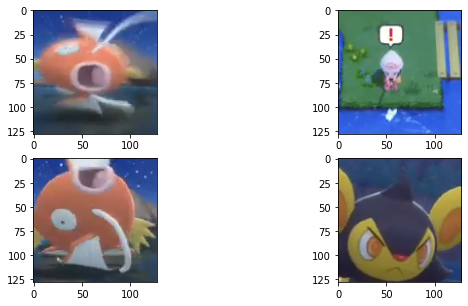

In [106]:
_, ax = plt.subplots(2, 2, figsize=(10, 5))
ax[0, 0].imshow(crop_middle(yes0_koi_img))
ax[0, 1].imshow(crop_middle(no0_koi_img))
ax[1, 0].imshow(crop_middle(yes1_koi_img))
ax[1, 1].imshow(crop_middle(no1_koi_img))
plt.show()


# LABELED


In [107]:
image_path = Path("labeled")

images = sorted(list(map(str, list(image_path.glob("*.png")))))
labels = [img.split(os.path.sep)[-1].split(".png")[0].split("_")[1] for img in images]


In [108]:
print("Number of images found: ", len(images))
print("Number of labels found: ", len(labels))
print("Number of YES", sum(1 for n in labels if n.find("yes") >= 0))
print("Number of No", sum(1 for n in labels if n.find("yes") < 0))


Number of images found:  3737
Number of labels found:  3737
Number of YES 255
Number of No 3482


In [45]:
# # remove some no
# filtered_img = []
# filtered_label = []

# for i, (img, label) in enumerate(zip(images, labels)):
#     if not (label.find("yes") < 0 and i % 8 > 0):
#         filtered_img.append(img)
#         filtered_label.append(label)

# print("Number of images found: ", len(filtered_img))
# print("Number of labels found: ", len(filtered_label))
# print("Number of YES", sum(1 for n in filtered_label if n.find("yes") >= 0))
# print("Number of No", sum(1 for n in filtered_label if n.find("yes") < 0))


# Prepare dataset


In [109]:
# Hyperparameter
BATCH_SIZE = 16
IMG_WIDTH = 128
IMG_HEIGHT = 128


In [110]:
x_train, x_test, y_train, y_test = train_test_split(images, labels, test_size=0.2)
x_train, x_val, y_train, y_val = train_test_split(
    x_train, y_train, test_size=0.25
)  # 0.25 x 0.8 = 0.2


In [111]:
def encode_single_sample(img_path, label):
    # 1. Read image
    img = tf.io.read_file(img_path)
    # 2. Decode and convert to grayscale
    img = tf.io.decode_png(img, channels=3)
    label = 1 if label == "yes" else 0
    # 7. Return a dict as our model is expecting two inputs
    return (img, label)


In [112]:
train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_dataset = (
    train_dataset.map(encode_single_sample, num_parallel_calls=tf.data.AUTOTUNE)
    .batch(BATCH_SIZE)
    .prefetch(buffer_size=tf.data.AUTOTUNE)
)

validation_dataset = tf.data.Dataset.from_tensor_slices((x_val, y_val))
validation_dataset = (
    validation_dataset.map(encode_single_sample, num_parallel_calls=tf.data.AUTOTUNE)
    .batch(BATCH_SIZE)
    .prefetch(buffer_size=tf.data.AUTOTUNE)
)

test_dataset = tf.data.Dataset.from_tensor_slices((x_test, y_test))
test_dataset = (
    test_dataset.map(encode_single_sample, num_parallel_calls=tf.data.AUTOTUNE)
    .batch(BATCH_SIZE)
    .prefetch(buffer_size=tf.data.AUTOTUNE)
)


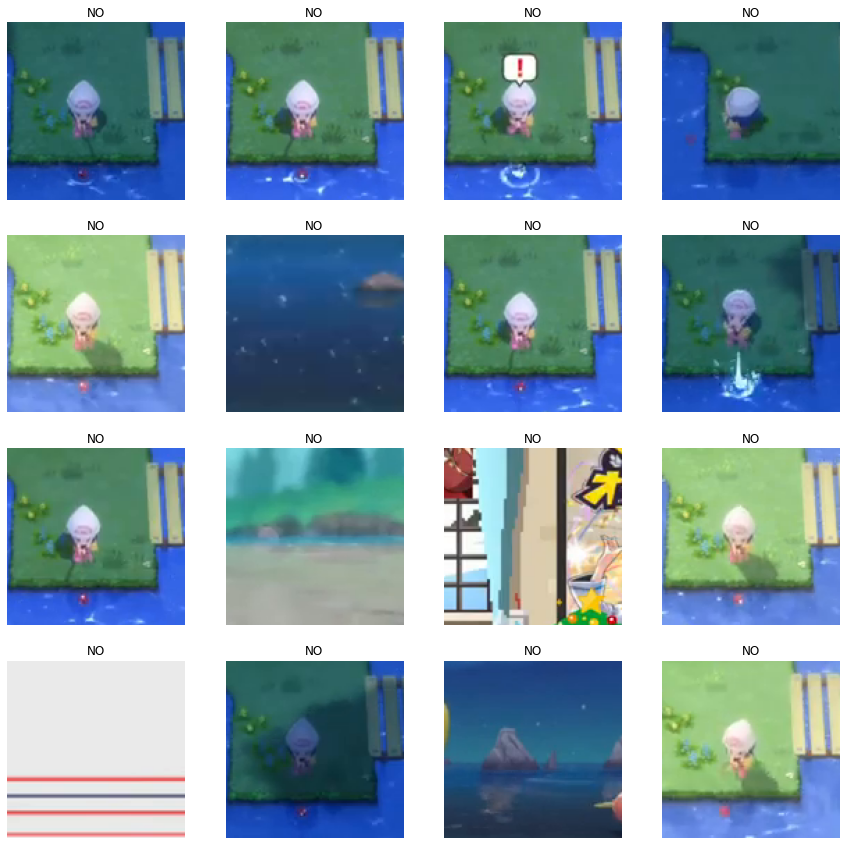

In [113]:
import matplotlib.pyplot as plt

_, ax = plt.subplots(4, 4, figsize=(15, 15))
for batch in train_dataset.take(1):
    imgs = batch[0]
    lls = batch[1]
    for i in range(16):
        img = (imgs[i]).numpy().astype("uint8")
        label = "YES" if lls[i] else "NO"
        ax[i // 4, i % 4].imshow(img)
        ax[i // 4, i % 4].set_title(label)
        ax[i // 4, i % 4].axis("off")


# MODEL Training


In [114]:
# data argumentation
data_augmentation = models.Sequential(
    [
        layers.RandomFlip("horizontal_and_vertical"),
        layers.RandomRotation(0.2),
        layers.RandomZoom(0.2),
    ]
)

resize_and_rescale = models.Sequential(
    [
        layers.Resizing(IMG_HEIGHT, IMG_WIDTH, input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)),
        layers.Rescaling(1.0 / 255)
    ]
)


## Custom net


In [128]:
model = models.Sequential(
    [
        resize_and_rescale,
        data_augmentation,
        layers.Conv2D(16, 3, padding="same", activation="relu"),
        layers.MaxPooling2D(),
        layers.Conv2D(32, 3, padding="same", activation="relu"),
        layers.MaxPooling2D(),
        layers.Conv2D(64, 3, padding="same", activation="relu"),
        layers.MaxPooling2D(),
        layers.Flatten(),
        layers.Dense(512, activation="relu"),
        layers.Dropout(0.5),
        layers.Dense(1, activation="sigmoid", name="output"),
    ],
    name="CNN",
)

model.compile(
    loss=losses.BinaryCrossentropy(),
    optimizer="adam",
    metrics=[metrics.BinaryAccuracy()],
)

model.summary()


Model: "CNN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_14 (Sequential)  (None, 128, 128, 3)       0         
                                                                 
 sequential_13 (Sequential)  (None, 128, 128, 3)       0         
                                                                 
 conv2d_12 (Conv2D)          (None, 128, 128, 16)      448       
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 64, 64, 16)       0         
 g2D)                                                            
                                                                 
 conv2d_13 (Conv2D)          (None, 64, 64, 32)        4640      
                                                                 
 max_pooling2d_13 (MaxPoolin  (None, 32, 32, 32)       0         
 g2D)                                                          

## MobileNet v3 small


In [118]:
base_model = applications.MobileNetV3Small(
    include_top=False,
    include_preprocessing=False,
    weights="imagenet",
    input_shape=(IMG_HEIGHT, IMG_WIDTH, 3),
)

base_model.trainable = False

model = models.Sequential(
    [
        resize_and_rescale,
        data_augmentation,
        base_model,
        layers.GlobalMaxPooling2D(),
        layers.Dense(512, activation="relu"),
        layers.Dropout(0.5),
        layers.Dense(1, activation="sigmoid", name="output"),
    ],
    name="Transferred_mobilenet",
)

model.compile(
    loss=losses.BinaryCrossentropy(),
    optimizer="adam",
    metrics=[metrics.BinaryAccuracy()],
)

model.summary()


Model: "Transferred_mobilenet"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_14 (Sequential)  (None, 128, 128, 3)       0         
                                                                 
 sequential_13 (Sequential)  (None, 128, 128, 3)       0         
                                                                 
 MobilenetV3small (Functiona  (None, 1, 1, 1024)       1529968   
 l)                                                              
                                                                 
 global_max_pooling2d_11 (Gl  (None, 1024)             0         
 obalMaxPooling2D)                                               
                                                                 
 dense_24 (Dense)            (None, 512)               524800    
                                                                 
 dropout_17 (Dropout)        (None, 512)     

In [129]:
epochs = 50
# early_stopping_patience = 10
# # Add early stopping
# early_stopping = tf.keras.callbacks.EarlyStopping(
#     monitor="val_loss", patience=early_stopping_patience, restore_best_weights=True
# )

# Train the model
history = model.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=epochs,
)

Epoch 1/50
141/141 [==============================] - 13s 89ms/step - loss: 0.2772 - binary_accuracy: 0.9264 - val_loss: 0.2378 - val_binary_accuracy: 0.9305
Epoch 2/50
141/141 [==============================] - 13s 89ms/step - loss: 0.1569 - binary_accuracy: 0.9424 - val_loss: 0.2120 - val_binary_accuracy: 0.9358
Epoch 3/50
141/141 [==============================] - 12s 88ms/step - loss: 0.0684 - binary_accuracy: 0.9808 - val_loss: 0.0424 - val_binary_accuracy: 0.9960
Epoch 4/50
141/141 [==============================] - 12s 88ms/step - loss: 0.0642 - binary_accuracy: 0.9826 - val_loss: 0.0279 - val_binary_accuracy: 0.9933
Epoch 5/50
141/141 [==============================] - 12s 88ms/step - loss: 0.0502 - binary_accuracy: 0.9853 - val_loss: 0.0157 - val_binary_accuracy: 0.9973
Epoch 6/50
141/141 [==============================] - 13s 91ms/step - loss: 0.0459 - binary_accuracy: 0.9875 - val_loss: 0.0146 - val_binary_accuracy: 0.9987
Epoch 7/50
141/141 [==============================] 

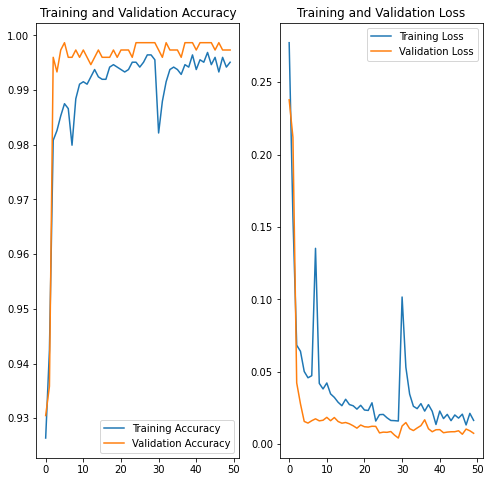

In [130]:
acc = history.history["binary_accuracy"]
val_acc = history.history["val_binary_accuracy"]

loss = history.history["loss"]
val_loss = history.history["val_loss"]

epochs_range = range(len(history.history["loss"]))

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label="Training Accuracy")
plt.plot(epochs_range, val_acc, label="Validation Accuracy")
plt.legend(loc="lower right")
plt.title("Training and Validation Accuracy")

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label="Training Loss")
plt.plot(epochs_range, val_loss, label="Validation Loss")
plt.legend(loc="upper right")
plt.title("Training and Validation Loss")
plt.show()


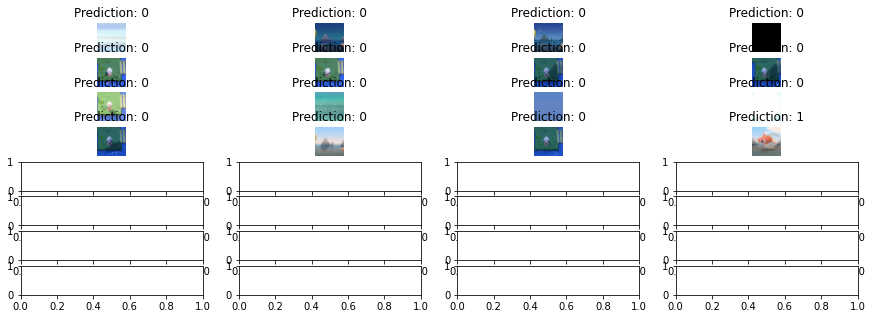

In [131]:
# A utility function to decode the output of the network
def decode_batch_predictions(x):
    return np.where(x > 0.5, 1, 0).flatten()


#  Let's check results on some validation samples
for batch in validation_dataset.take(1):
    batch_images = batch[0]
    batch_labels = batch[1]

    preds = model.predict(batch_images)
    pred_texts = decode_batch_predictions(preds)

    orig_texts = []
    for label in batch_labels:
        label = "YES" if label else "NO"
        orig_texts.append(label)

    _, ax = plt.subplots(8, 4, figsize=(15, 5))
    for i in range(len(pred_texts)):
        img = batch_images[i].numpy()
        img = img
        title = f"Prediction: {pred_texts[i]}"
        ax[i // 4, i % 4].imshow(img)
        ax[i // 4, i % 4].set_title(title)
        ax[i // 4, i % 4].axis("off")
plt.show()


# TEST


In [132]:
#  Let's check results on some validation samples
truths = []
predictions = []
imgs = []


for batch in list(test_dataset):
    batch_images = batch[0]
    batch_labels = batch[1]
    
    out = model.predict(batch_images)
    

    preds = decode_batch_predictions(out)

    for (label, pred, img) in zip(batch_labels, preds, batch_images):
        truths.append(int(label))
        predictions.append(pred)
        imgs.append(imgs)


Lesions Detected (True Negatives):  700
Lesions Incorrectly Detected (False Positives):  6
No-Lesions Missed (False Negatives):  3
No-Lesions Detected (True Positives):  39
Total Lesions:  42


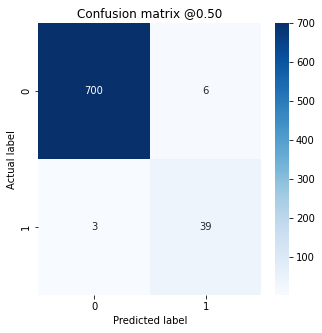

In [133]:
def plot_cm(labels, predictions, p: float = 0.5):
    cm = confusion_matrix(labels, predictions)
    # you can normalize the confusion matrix

    plt.figure(figsize=(5, 5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.title("Confusion matrix @{:.2f}".format(p))
    plt.ylabel("Actual label")
    plt.xlabel("Predicted label")

    print("Lesions Detected (True Negatives): ", cm[0][0])
    print("Lesions Incorrectly Detected (False Positives): ", cm[0][1])
    print("No-Lesions Missed (False Negatives): ", cm[1][0])
    print("No-Lesions Detected (True Positives): ", cm[1][1])
    print("Total Lesions: ", np.sum(cm[1]))


plot_cm(truths, predictions)


In [134]:
model.evaluate(test_dataset, batch_size=BATCH_SIZE)


47/47 [==============================] - ETA: 0s - loss: 0.0445 - binary_accuracy: 0.987 - 1s 18ms/step - loss: 0.0438 - binary_accuracy: 0.9880


[0.04376592859625816, 0.9879679083824158]

In [135]:
model.save('cnn.h5')